# Cross-Validatded Elastic-Net
The purpose of this script is to use an elsatic-net model with cross-validated test error, alpha values, and lambda values. This will be used to predict life expectancy using a cut of the HRS data set.

In [18]:
# Show all columns.
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

df = read.csv('le_svm.csv')
dim(df)
head(df)

[1] 13132    54

hhidpn,wave,mstat,cendiv,gender,rahispan,raracem,iwbeg,dage_m,dage_y,raedyrs,rarelig,ravetrn,agey_m,shlt,shltc,depres,effort,sleepr,cesd,bmi,smokev,smoken,drinkn,hibp,diab,cancr,lung,heart,strok,psych,arthr,conde,cogtot,slfmem,pstmem,spcfac,hsptim,puff,puffpos,timwlk,hatotb,iearn,isret,covs,hiltc,lbrf,logiearn,logisret,loghspti,loghatotb,id,nt,n2
3010,3,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,13345,931,77,12,1.protestant,0.no,60,3.good,-1,1.yes,1.yes,1.yes,3,28.0,0.no,0.no,1,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,35,4.fair,2.same,0.no,0,,,,490500,4000,0,1.yes,1.yes,4.partly retired,8.294050,0.000000,0,13.10318,2,123702,7
3010,6,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,15445,931,77,12,1.protestant,0.no,66,3.good,-1,0.no,0.no,0.no,1,28.3,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,31,3.good,2.same,0.no,0,,,,704000,10000,13728,0.no,1.yes,4.partly retired,9.210340,9.527193,0,13.46453,3,123702,7
3010,7,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,16267,931,77,12,1.protestant,0.no,68,3.good,0,0.no,0.no,0.no,0,26.6,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,18,3.good,2.same,0.no,0,,,,756000,6000,15600,0.no,1.yes,4.partly retired,8.699515,9.655026,0,13.53580,4,123702,7
3010,8,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,16875,931,77,12,1.protestant,0.no,70,3.good,0,0.no,0.no,0.no,0,27.1,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,20,4.fair,2.same,0.no,0,490,1.standing,2.78,914000,0,14040,0.no,1.yes,5.retired,0.000000,9.549666,0,13.72559,5,123702,7
3010,9,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,17577,931,77,12,1.protestant,0.no,72,3.good,0,0.no,0.no,0.no,0,24.7,0.no,0.no,1,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,26,3.good,2.same,0.no,1,.a,.a=r not asked phys meas this wave,.a,1156000,0,15600,0.no,1.yes,5.retired,0.000000,9.655026,0,13.96048,6,123702,7
3010,10,1.married,9.pacific,1.male,0.not hispanic,1.white/caucasian,18520,931,77,12,1.protestant,0.no,74,3.good,0,0.no,0.no,0.no,0,24.0,0.no,0.no,0,0.no,0.no,0.no,0.no,1.yes,0.no,0.no,0.no,1,17,4.fair,3.worse,0.no,0,330,1.standing,3.0999999,1240000,0,16644,0.no,1.yes,5.retired,0.000000,9.719805,0,14.03062,7,123702,7


### Create test and training sets.

In [5]:
# Specify data as numeric or factor
# Doesn't like dents
df = na.omit(df)
names_factor = c('gender', 'raracem', 'rahispan', 'mstat', 'shlt', 
                 'depres', 'cendiv' , 'effort', 
                 'sleepr', 'arthr','heart', 'strok', 'psych', 'cancr', 'wave',
                  'slfmem', 'covs',
                  'lbrf', 'smokev',  'hiltc',
                  'spcfac', 'rarelig','ravetrn')
df[,names_factor] = lapply(df[,names_factor], factor)
names_numeric = c('iearn', 'logiearn', 'bmi', 'cogtot','drinkn',
                   'dage_y','conde', 'raedyrs',
                  'logisret', 'loghatotb','loghspti')
df[,names_numeric] = lapply(df[,names_numeric], as.numeric)
dim(df)

[1] 13132    54

In [6]:
#This is the weak model.
#Create tests and training sets.
n = dim(df)[1]
training_ratio = .8
train_size = sort(sample(1:n, training_ratio*n))
train = na.omit(df[train_size,])
test = na.omit(df[-train_size,])
# We can also test for death age at month. 
# Interact puff*puffpos, shlt*shltc
train_mat = model.matrix(dage_y ~ cogtot+ gender + raracem + rahispan + agey_m +logiearn +
                         shlt + shltc +raedyrs +mstat +
                        bmi +smoken + hibp + drinkn + pstmem + 
                         + depres + cendiv + effort + bmi*bmi
                        +  sleepr + bmi + smoken + drinkn + arthr + heart + strok + psych + cancr
                         + diab  + lung + slfmem + pstmem  + covs
                          + lbrf + raedyrs + smokev + hibp + conde 
                          + hiltc  + spcfac + loghspti + rarelig + ravetrn  
                          + loghatotb + loghspti , train)
test_mat = model.matrix(dage_y ~ cogtot+ gender + raracem + rahispan + agey_m +logiearn +
                         shlt + shltc +raedyrs +mstat +
                        bmi +smoken + hibp + drinkn + pstmem + 
                         + depres + cendiv + effort + bmi*bmi
                        +  sleepr + bmi + smoken + drinkn + arthr + heart + strok + psych + cancr
                         + diab  + lung + slfmem + pstmem  + covs
                          + lbrf + raedyrs + smokev + hibp + conde 
                          + hiltc  + spcfac + loghspti + rarelig + ravetrn  
                          + loghatotb + loghspti , test)

In [7]:
# Test to make sure |imensions are square.
dim(train_mat)
dim(test_mat)
dim(train)
dim(test)
sum(is.na(train_mat))
sum(is.na(test_mat))
#typeof(train_mat[1])
#train_mat

[1] 10505    94

[1] 2627   94

[1] 10505    54

[1] 2627   54

[1] 0

[1] 0

# CV GLMNET
### For variable selection.

Here I will use the glmulti() to try every combination of predictors and their pairwise interactions. \
https://www.youtube.com/watch?v=Im293ClFen4&t=342s

In [65]:
#help(cv.glmnet)

In [66]:
#help(predict.cv.glmnet)

[1] "This is one iteration of what the below function carries out.\nThis iteration is known as a Lasso Regression. This is becaus the alpha is set to 1.\nWhere the function below iterates through all alphas.\nThis allows us to test ridge regression(alpha = 0), lasso(alpha = 1), and inbetween at various steps.\n"

[1] "RMSE"


[1] 7.618168

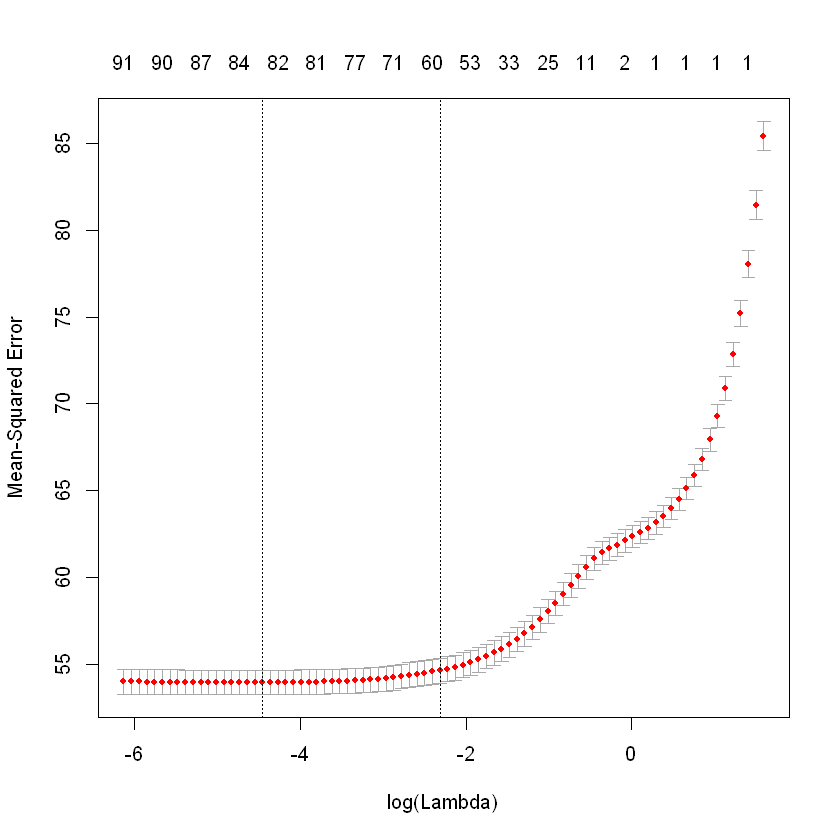

In [67]:
'This is one iteration of what the below function carries out.
This iteration is known as a Lasso Regression. This is becaus the alpha is set to 1.
Where the function below iterates through all alphas.
This allows us to test ridge regression(alpha = 0), lasso(alpha = 1), and inbetween at various steps.
'
#Store list
list_of_fit = list
a = cv.glmnet(train_mat, train$dage_y, 
                      type.measure = 'mse', alpha = 1, 
                      family = 'gaussian')

pred = predict(a, s = a$lambda.1se, test_mat, type = 'response')
rmse = sqrt(mean((pred - test$dage_y)^2))
print('RMSE')
rmse
plot(a)

In [69]:
# Elastic Net function.
#load the library and set seed if desired.
library(glmnet)

# alhpa_step represents how the number of steps alpha will test between 0 and 1. 
# '.01' for alpha will produce 100 models and '.1' will produce 10.
elastic_net = function(df, train_mat, test_mat, y_var, alpha_step){
    
    # Create's list of alphas to try.
    alphas = seq(0,1, by = alpha_step)
    #Store list
    list_of_fit = list()
    
    # Produce models.
    # Optimizes lambda then produces a model for each alhpa. 
    for(i in alphas){
        fit_name = paste0('alpha', i)
    
        list_of_fit[[fit_name]] = cv.glmnet(train_mat, train$dage_y, 
                      type.measure = 'mse', alpha = i, 
                      family = 'gaussian')
    }
    
    # Predict values
    results = data.frame()
    for(i in alphas){
        fit_name = paste0('alpha', i)
        
        predicted = predict(list_of_fit[[fit_name]], 
                            s = list_of_fit[[fit_name]]$lambda.1se,
                            test_mat, type = 'response')
        
        rmse = sqrt(mean((predicted - test$dage_y)^2))
        mse = mean((predicted - test$dage_y)^2)
        
        temp = data.frame(alpha = i, rmse = rmse, mse = mse, fit.name = fit_name)
        results = rbind(results, temp)
    }
    return(results)
    }

results = elastic_net(df, train_mat, test_mat, df$dage_y, .01)

In [70]:
# Convert list to dataframe.
# List 10 best models. 
results %>% arrange(mse) %>% head(10)

alpha,rmse,mse,fit.name
0.60,7.580769,57.46806,alpha0.6
0.56,7.584856,57.53004,alpha0.56
0.35,7.587662,57.57262,alpha0.35
0.69,7.588839,57.59048,alpha0.69
0.41,7.591500,57.63087,alpha0.41
0.16,7.592211,57.64167,alpha0.16
0.10,7.592228,57.64192,alpha0.1
0.95,7.593260,57.65759,alpha0.95
0.94,7.593289,57.65804,alpha0.94
0.88,7.593477,57.66090,alpha0.88


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


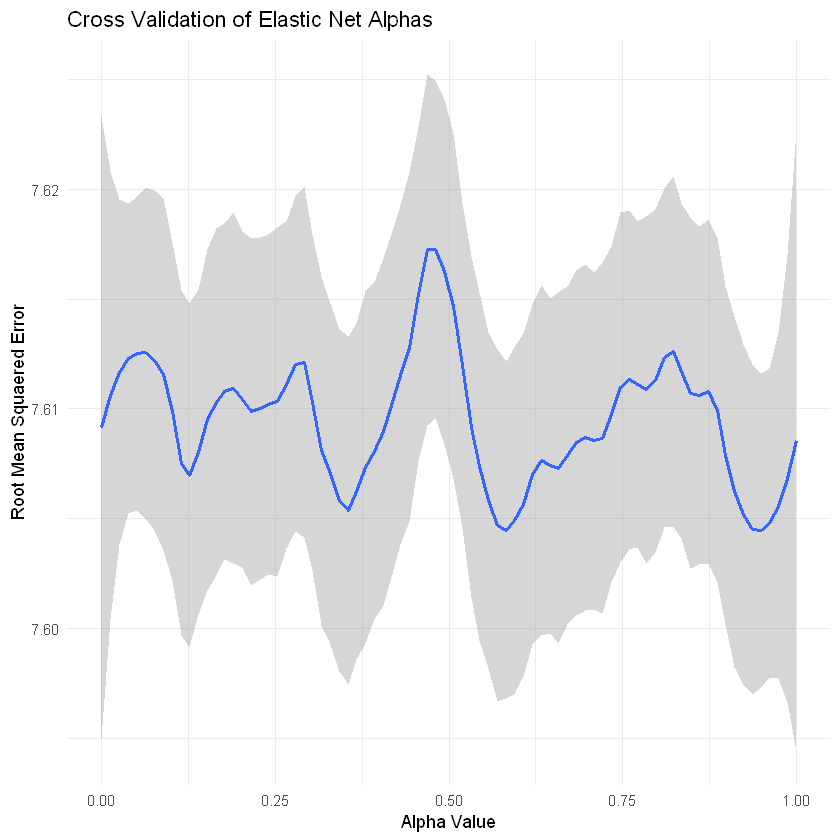

In [71]:
x = results$alpha
y = results$mse
y2 = results$rmse
# Below sets up function to scale variable.
scaleFUN <- function(x) sprintf("%.2f", x)
qplot(x,y2, geom = 'smooth', span = .2) +
    ggtitle("Cross Validation of Elastic Net Alphas") +
    xlab("Alpha Value") + ylab("Root Mean Squaered Error")+
    scale_y_continuous(labels=scaleFUN) +
    theme_minimal()

[1] "MSE of best model"

[1] 57.79018

[1] "RMSE of best model"

[1] 7.601985

95 x 1 sparse Matrix of class "dgCMatrix"
                                                 1
(Intercept)                          -29.832706834
(Intercept)                            .          
cogtot                                 .          
gender2.female                         0.001589976
raracem2.black/african american       -0.786579187
raracem3.other                        -2.484980470
rahispan1.hispanic                    -2.499580675
agey_m                                 0.587750358
logiearn                               .          
shlt2.very good                       -0.860460122
shlt3.good                             .          
shlt4.fair                             0.371182036
shlt5.poor                             0.635500814
shltc-2                                0.553256859
shltc-3                                0.115169883
shltc-4                                0.346869073
shltc.m                                .          
shltc.p                                3

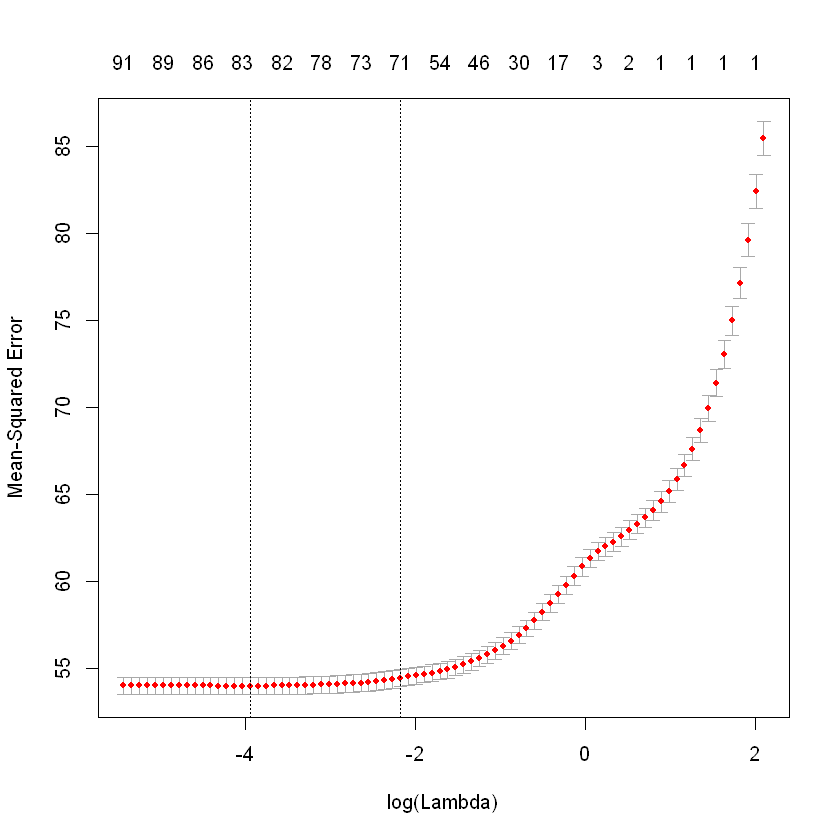

In [75]:
m1 = cv.glmnet(train_mat, train$dage_y, 
                      type.measure = 'mse', alpha = .6, 
                      family = 'gaussian')
predicted2 = predict(m1, 
                            s = m1$lambda.1se,
                            test_mat, type = 'response')
        
rmse = sqrt(mean((predicted2 - test$dage_y)^2))
mse = mean((predicted2 - test$dage_y)^2)
'MSE of best model'
mse
'RMSE of best model'
rmse 
plot(m1)
coef(m1)

In [76]:
# Report the alhpa value 1 standard error from the 
m1$lambda.1se

[1] 0.1135173